# Archgit - How To Create A Commit From Scratch

Many software developers use Git every day, but have you ever wondered how all of the Git magic acutally works? "Sure it uses hashes and stuff" is what you may be thinking right now. Which is correct by the way but it is only part of the story. I will try to enlighten you with some details about the guts of git with this interactive notebook.

To do so I will explain how to create a basic Git repository and commit a file without using any git commands all. Welcome to Archgit or how to create a commit from scratch! Without further ado, let's get started!

First we need to create a bare bones repository. With `git init` the repository is already bloated with lots of unnecessary stuff...

In [1]:
!git init -q ./bloated
!tree ./bloated/.git/
!rm -rf ./bloated

./bloated/.git/
├── HEAD
├── config
├── description
├── hooks
│   ├── applypatch-msg.sample
│   ├── commit-msg.sample
│   ├── fsmonitor-watchman.sample
│   ├── post-update.sample
│   ├── pre-applypatch.sample
│   ├── pre-commit.sample
│   ├── pre-push.sample
│   ├── pre-rebase.sample
│   ├── pre-receive.sample
│   ├── prepare-commit-msg.sample
│   └── update.sample
├── info
│   └── exclude
├── objects
│   ├── info
│   └── pack
└── refs
    ├── heads
    └── tags

8 directories, 15 files


What we actually only need is the `.git` directory with the `HEAD` file, which tells git from where to start to build our working directory, as well as the `objects` and `refs` direcotries. The `objects` directory is where Git actually stores all the data and the `refs` directory enables us to save references to specific points in time in a human readable or rather rememberable format.

In [2]:
!mkdir -p basicrepo/.git/refs/heads
!mkdir -p basicrepo/.git/objects
!echo "ref: refs/heads/master" >> ./basicrepo/.git/HEAD
!tree basicrepo/.git
!git --git-dir=$PWD/basicrepo/.git --work-tree=$PWD/basicrepo status

basicrepo/.git
├── HEAD
├── objects
└── refs
    └── heads

3 directories, 1 file
On branch master

No commits yet

nothing to commit (create/copy files and use "git add" to track)


As we can see `git status` is happy with our minimal repository and says that we are on the *master* branch, which is a little bit of a lie at the moment since there is no reference to the *master* branch in `refs/heads`.

Let's takse this opportunity to get into how git actually stores *things* and first and foremost what kind of *things* there actually are

## Things in Git - Blobs, Trees and Commits

Git basically knows three kinds of objects (there are more but they are not important for the scope of this tutorial): Blobs, trees and commits. Blobs represent the contents of the files, trees represent the structure of the repository (one can think of them as the filesystem of git) and commits represent snapshots of the repository including some additional information.

All of these objects are stored in a compressed (using *zlib*), binary format in the `.git/objects` directory. To reference them the SHA-1 hash function is used to create a unique 20 byte fingerprint for each object. The first two hex characters are the directory and the remaining 38 characters are the filename. This prevents a very flat hierarchy and is easier for an OS to handle.

## Blobs

Let's start all the way at the bottom. A blob represents a chunk (or blob for that matter) of binary data. This is the basic way that Git saves all its files.

The format of a blob is as follows:  
>blob \[*size of content*\]\\u0000\[*content*\]  
>
>For example:  
>blob 25\u0000This is the README file.\n

So let's create our very own blob

In [8]:
import os
import zlib
from hashlib import sha1

content = 'Hello World\n'
header = f'blob {len(content)}\u0000'
store = header + content

# Create the fingerprint to reference our blob later
digest = sha1(store.encode('utf-8')).hexdigest()
compressed = zlib.compress(store.encode('utf-8'))

print('Content: ', content)
print('Header:', header)
print('Store:', store)
print('Digest:', digest)
print('Dir:', digest[:2])
print('File:', digest[2:])
print('\nCompressed:', compressed)

os.makedirs(os.path.dirname(f'basicrepo/.git/objects/{digest[:2]}/'))
with open(f'basicrepo/.git/objects/{digest[:2]}/{digest[2:]}', 'wb') as blob:
    blob.write(compressed)


Content:  Hello World

Header: blob 12 
Store: blob 12 Hello World

Digest: 557db03de997c86a4a028e1ebd3a1ceb225be238
Dir: 55
File: 7db03de997c86a4a028e1ebd3a1ceb225be238

Compressed: b'x\x9cK\xca\xc9OR04b\xf0H\xcd\xc9\xc9W\x08\xcf/\xcaI\xe1\x02\x00A\xd1\x06I'


We have now created our first Git object and will now examine it more closely to verify that Git actually understands the file that we have just created.  
For this we will use the Git command (yes, yes I said no Git commands but bear with me) `git cat-file`.

In [16]:
!tree basicrepo/.git
!echo '\nType of object:'
!git --git-dir=$PWD/basicrepo/.git cat-file -t 557d
!echo 'Content of object:'
!git --git-dir=$PWD/basicrepo/.git cat-file -p 557d
!echo 'Raw content:'
!cat basicrepo/.git/objects/55/7db03de997c86a4a028e1ebd3a1ceb225be238

basicrepo/.git
├── HEAD
├── objects
│   └── 55
│       └── 7db03de997c86a4a028e1ebd3a1ceb225be238
└── refs
    └── heads

4 directories, 2 files

Type of object:
blob
Content of object:
Hello World
Raw content:
x�K��OR04b�H����/�I� A�I

As you can see, Git understands that our object is a blob and that it's content is *'Hello World\n'* and we used the digest to reference it (in most cases the first four hex characters are enough to uniquely identify the object we mean but we could be more exact here). So far so good!  

An interesting thing to note here is that we stored only the content of a file in the blob, not including a filename, for example. This means that two files with identical content will result in the same blob and therefore are only saved once.  

But how does Git then know my filenames? Good question, let's move on!

## Trees
Trees are used to represent the file system in a repository. They can answer questions like: What is the name of a file? Which directories are there? etc.  
They are also used to build your working tree when you checkout a branch, by the way.

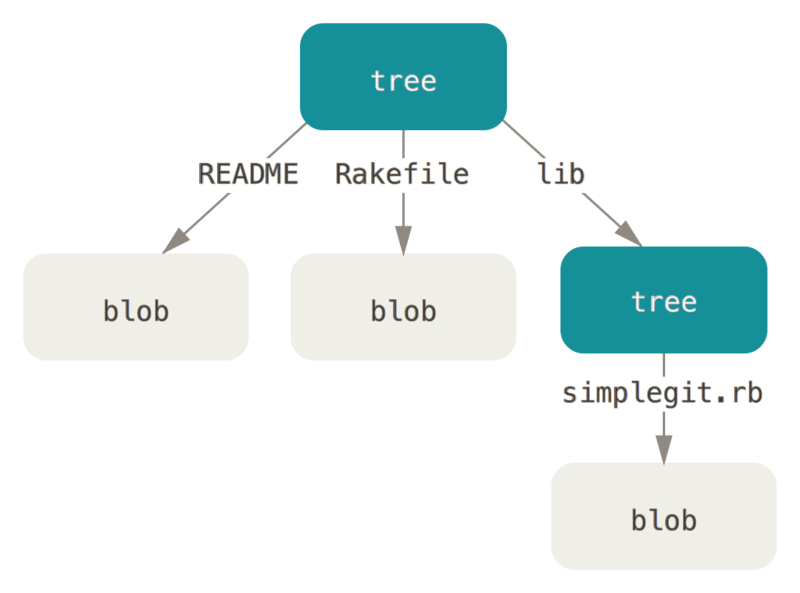

The filesystem is build by trees referencing other trees or blobs as seen in the figure above. Each entry in the tree object associates a name to another object which is either a tree or a blob. The resulting structure of the figure above would be a root directory with two files (README and Rakefile) and a subdirectory called lib which in turn is a tree object which references a third file named simplegit.rb.  
So a tree object could have two entries with different names but referencing the same blob which would create two files with identical content but different names.

The format of a tree object is as follows:  
> tree \[*content size*\]\\u0000\[*Entries having references to other trees and blobs*\]  
With each entry having the format:  
> \[mode\] \[*file/directory name*\]\\u0000\[*SHA-1 of referenced blob or tree (as bytes)*\]